***Importing Required Libraries***

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from wordcloud import WordCloud
import plotly.express as px

plt.style.use('seaborn')
sns.set_palette('coolwarm')


<ipython-input-1-00a6077ce050>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


***Loading the Dataset***

In [ ]:
df = pd.read_csv('/content/twitter_training.csv')

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       74682 non-null  int64 
 1   entity         74682 non-null  object
 2   sentiment      74682 non-null  object
 3   Tweet Content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


,Tweet ID,entity,sentiment,Tweet Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


***Basic Data Cleaning***

In [ ]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^A-Za-z0-9\s]', '', text)
        return text.lower()
    else:
        return ""
df['cleaned_tweet'] = df['Tweet Content'].apply(clean_text)
df_cleaned = df.drop_duplicates(subset=['Tweet ID', 'cleaned_tweet'])
df_cleaned = df_cleaned[df_cleaned['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
df_cleaned[['Tweet ID', 'entity', 'sentiment', 'cleaned_tweet']].head()


,Tweet ID,entity,sentiment,cleaned_tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you all
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


***Basic Sentiment Distribution Analysis***

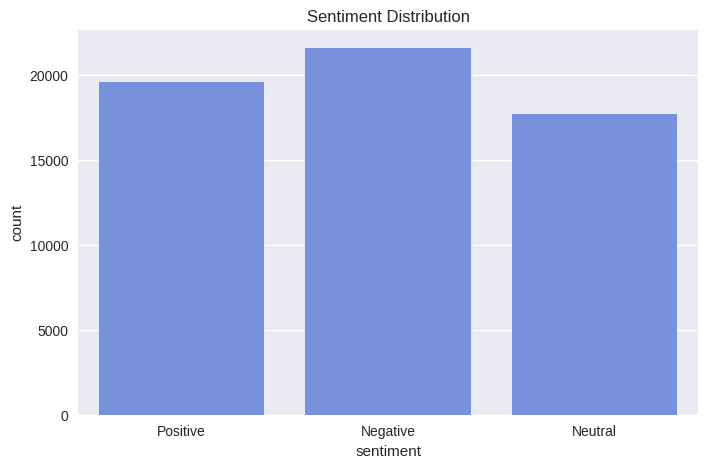

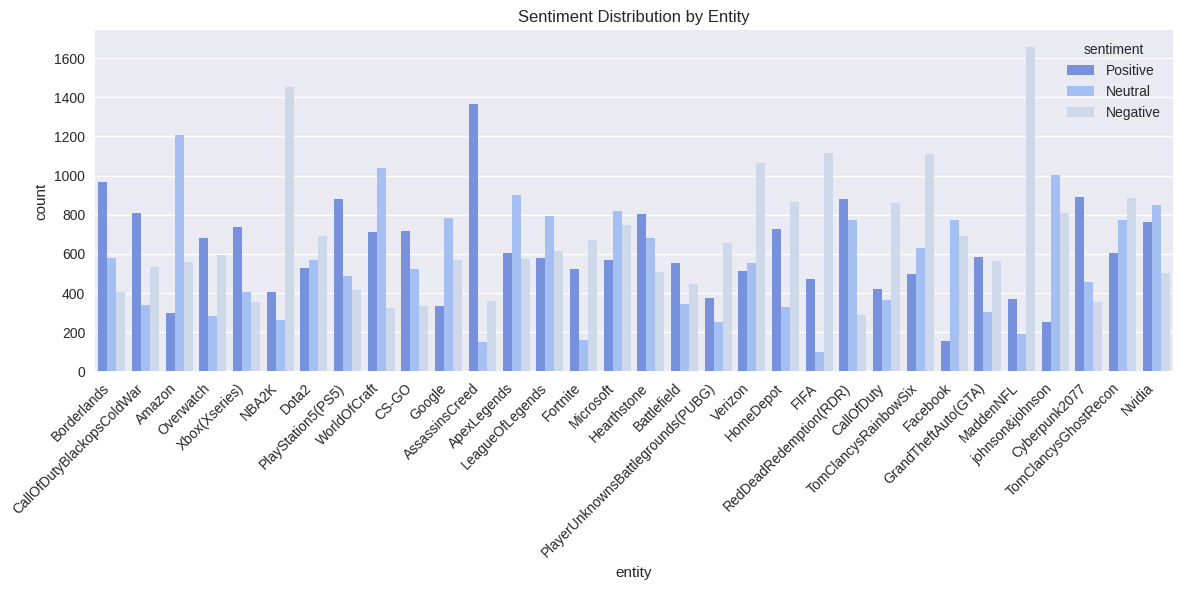

In [ ]:
sentiment_counts = df_cleaned['sentiment'].value_counts()

plt.figure(figsize=(8, 5))
sns.countplot(data=df_cleaned, x='sentiment', order=['Positive', 'Negative', 'Neutral'])
plt.title('Sentiment Distribution')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=df_cleaned, x='entity', hue='sentiment')
plt.title('Sentiment Distribution by Entity')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

***Sentiment Polarity Analysis using TextBlob***

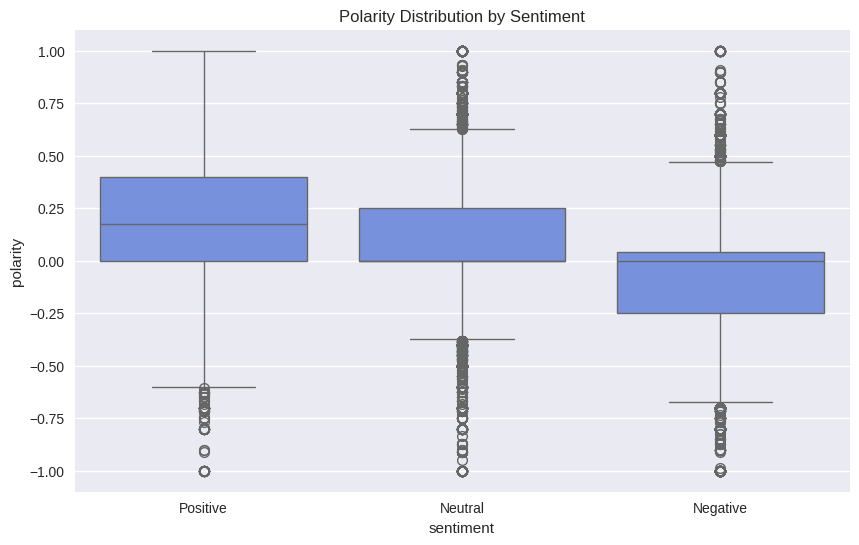

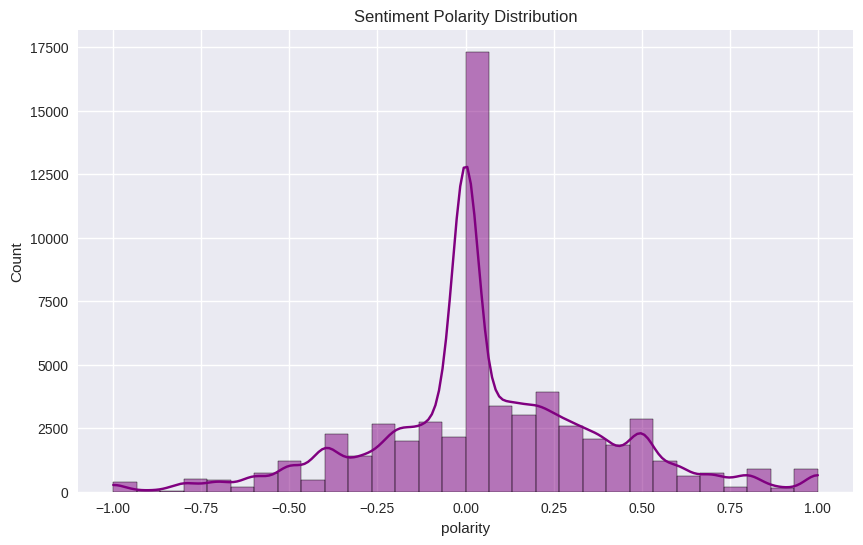

In [ ]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df_cleaned['polarity'] = df_cleaned['cleaned_tweet'].apply(get_polarity)

df_cleaned[['cleaned_tweet', 'sentiment', 'polarity']].head()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='sentiment', y='polarity')
plt.title('Polarity Distribution by Sentiment')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['polarity'], bins=30, kde=True, color='purple')
plt.title('Sentiment Polarity Distribution')
plt.show()

***Topic Modeling with LDA***

In [ ]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tweet_vectors = vectorizer.fit_transform(df_cleaned['cleaned_tweet'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tweet_vectors)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
game dead im red play fix like dont redemption just
Topic 1:
johnson just like people amazon baby access health overwatch powder
Topic 2:
just nvidia microsoft verizon pubg google best new fuck good
Topic 3:
just game im really good love rhandlerr playing time like
Topic 4:
video game new home play xbox black depot legends war


***Word Frequency Analysis by Sentiment***

In [ ]:
def get_word_freq(sentiment):
    words = ' '.join(df_cleaned[df_cleaned['sentiment'] == sentiment]['cleaned_tweet']).split()
    return Counter(words).most_common(10)
print("Top Positive Words:", get_word_freq('Positive'))
print("Top Negative Words:", get_word_freq('Negative'))
print("Top Neutral Words:", get_word_freq('Neutral'))


Top Positive Words: [('the', 11564), ('i', 8791), ('to', 7478), ('and', 6778), ('a', 5790), ('of', 4980), ('is', 4331), ('for', 4275), ('this', 4098), ('it', 3912)]
Top Negative Words: [('the', 13852), ('i', 9895), ('to', 8988), ('and', 8555), ('a', 7401), ('is', 6705), ('of', 5665), ('this', 4804), ('in', 4732), ('it', 4724)]
Top Neutral Words: [('the', 10478), ('to', 7048), ('and', 6254), ('a', 5854), ('i', 5398), ('of', 4850), ('for', 3946), ('in', 3921), ('is', 3298), ('on', 3140)]


***Word Cloud Visualization by Sentiment***

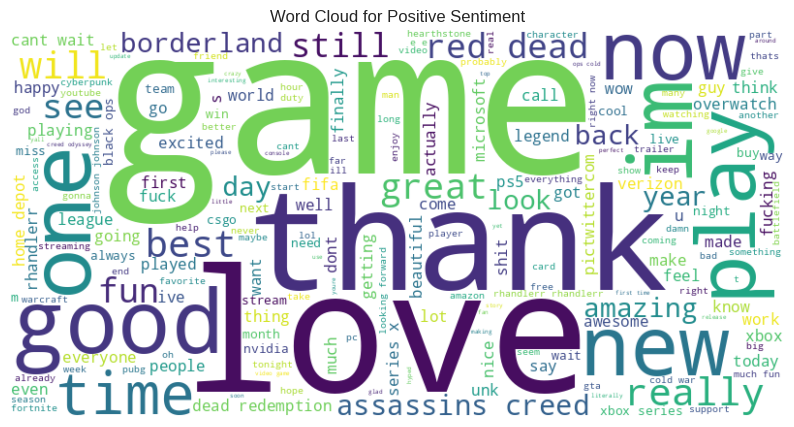

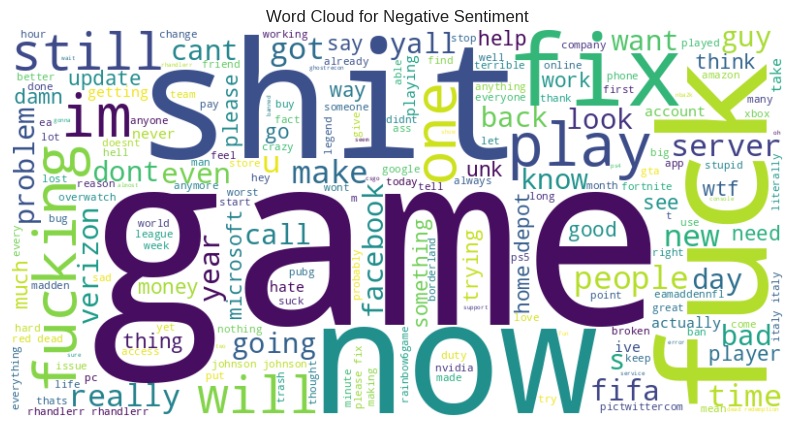

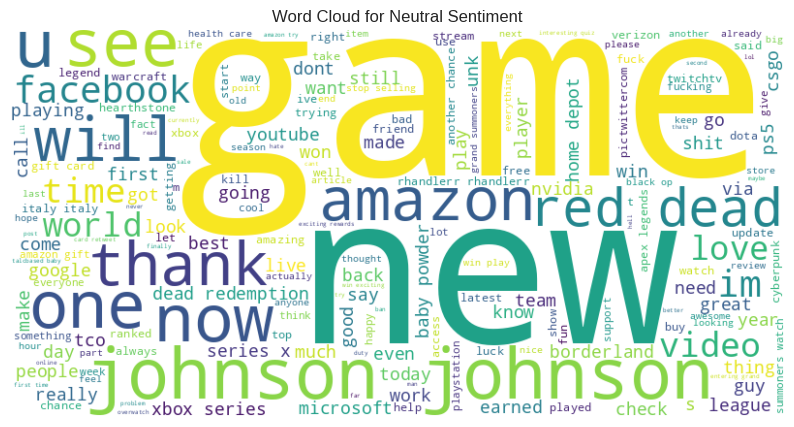

In [ ]:
def generate_wordcloud(sentiment):
    text = ' '.join(df_cleaned[df_cleaned['sentiment'] == sentiment]['cleaned_tweet'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.show()

generate_wordcloud('Positive')
generate_wordcloud('Negative')
generate_wordcloud('Neutral')


***Visualizing Sentiment Trends using Plotly***

In [ ]:
fig = px.bar(df_cleaned, x='entity', color='sentiment', barmode='group', title='Sentiment Distribution Across Entities')
fig.show()

fig = px.histogram(df_cleaned, x='polarity', color='sentiment', nbins=30, title='Sentiment Polarity Across Categories')
fig.show()
